In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import interpolate
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nibabel as nib
import os
import gc

In [2]:
!pwd

/home/ljd2160


In [2]:
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

# Dataloader

In [3]:
data_path = "~/research/OASIS1/LST/S0001"
annotations_file = "~/research/OASIS1/oasis_cross-sectional.csv"


In [4]:
class downsample(object):
    def __init__(self, downscale_factor):
        self.downscale_factor = downscale_factor

    def __call__(self, sample):
        sample = sample.float()
        original_size = sample.size()
        new_size = [int(original_size[0] * self.downscale_factor),
                    int(original_size[1] * self.downscale_factor),
                    int(original_size[2] * self.downscale_factor)]
        downsampled_image = interpolate(sample.unsqueeze(0).unsqueeze(0), size = new_size, mode='trilinear', align_corners = False)
        downsampled_image = downsampled_image.squeeze(0)
        return downsampled_image

In [5]:
class OASIS(Dataset):
    def __init__(self, annotations_file, data_path, transform = None):
        # clean up the csv file so that only the ID and CDR columns are left
        self.labels = pd.read_csv(annotations_file)
        self.labels = self.labels[['ID', 'CDR']]
        self.labels = self.labels.dropna(subset=['CDR'])
        self.labels = self.labels.reset_index(drop=True)
        self.labels['CDR'] = [1 if i> 0 else 0 for i in self.labels['CDR']]

        self.data_path = data_path

        self.transform = transform

    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        img_filename = self.labels.iloc[idx, 0].replace("MR1", "S0001_T1_O_nu_acpc.nii")
        img_path = os.path.join(data_path, img_filename)
        nifti = nib.load(img_path)
        img = np.float32(nifti.get_fdata())
        img = torch.from_numpy(img)
        if self.transform:
            img = self.transform(img)
        label = self.labels.iloc[idx, 1]
        return img, label

        

## test dataloader

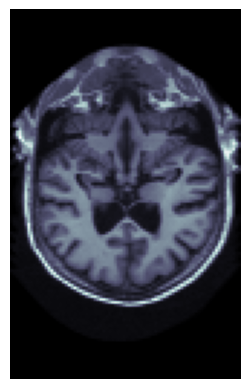

0
torch.Size([1, 128, 128, 80])


In [6]:
halfsample = downsample(0.5)
oasis = OASIS(annotations_file, data_path, halfsample)
img, label = oasis[0]
plt.imshow(img[0][50], cmap = 'bone')
plt.axis('off')
plt.show()
print(label)
print(img.shape)

## test and train split

In [7]:
train_size = int(0.8 * len(oasis))
valid_size = int(0.1 * len(oasis))
test_size = len(oasis) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(oasis, [train_size, valid_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = 2, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)
print(f"train size: {train_size}, validation size:  {valid_size}, test size:  {test_size}")

train size: 188, validation size:  23, test size:  24


torch.Size([2, 1, 128, 128, 80])

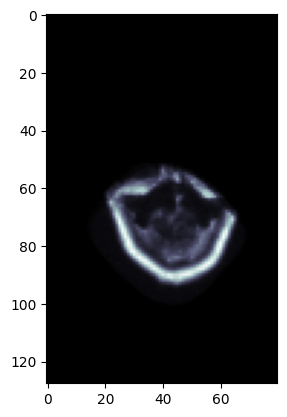

In [12]:
sample = next(iter(train_loader))
plt.imshow(sample[0][0][0][96], cmap = 'bone')
sample[0].shape

# NeuralNetwork

In [10]:
class vgg11(nn.Module):
    def __init__(self, num_channels, n_classes):
        super(vgg11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(num_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, n_classes),
            nn.Sigmoid()
        )   

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x.squeeze(1)
    


In [8]:
class MLPmodel(nn.Module):
    def __init__(self):
        super(MLPmodel, self).__init__()
        self.fc1 = nn.Linear(128*128*80, 128*8)
        self.fc2 = nn.Linear(128*8, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,1)

    def forward(self, x):
        x = x.view(-1, 128*128*80)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        x = self.fc4(x)
        x = F.sigmoid(x)
        return x.squeeze(1) 

my_MLP = MLPmodel()


## test output

# Training

In [9]:
optimizer = torch.optim.Adam(my_MLP.parameters(), lr=0.001)
loss_function = nn.BCELoss()

In [10]:
def train_net(net, epochs, train_dataloader, valid_loader, optimizer, loss_function):
    ret_train_loss = []
    ret_valid_loss = []
    for epoch in range(epochs):
        net.train()

        train_loss = []
        for i, (img, label) in enumerate(train_dataloader):
            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            y_pred = net(img)
            loss = loss_function(y_pred, label.float())
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        epoch_loss = np.mean(train_loss)
        ret_train_loss.append(epoch_loss)

        print(f"epoch {epoch}, loss: {epoch_loss}")
        
        net.eval()

        valid_loss = []
        for i, (img, label) in enumerate(valid_loader):
            img = img.to(device)
            label = label.to(device)
            y_pred = net(img)
            loss = loss_function(y_pred, label.float())
            valid_loss.append(loss.item())
        epoch_vloss = np.mean(valid_loss)
        print(f"epoch {epoch}, loss: {epoch_vloss}")
        ret_valid_loss.append(epoch_vloss)

    return ret_train_loss, ret_valid_loss 

In [16]:
def test_net(net, test_dataloader):
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (img, label) in enumerate(test_dataloader):
            img = img.to(device)
            label = label.to(device)
            y_pred = net(img)
            y_pred = torch.round(y_pred)
            total += label.size(0)
            correct += (y_pred == label).sum().item()
        print(f'Accuracy: {correct/total}')

In [18]:
torch.cuda.set_device(device)
gc.collect()
torch.cuda.empty_cache()

In [11]:
my_MLP.to(device)
train_loss, valid_loss = train_net(my_MLP, 10, train_loader, valid_loader, optimizer, loss_function)

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.00 GiB. GPU 1 has a total capacity of 23.64 GiB of which 3.40 GiB is free. Including non-PyTorch memory, this process has 20.23 GiB memory in use. Of the allocated memory 20.03 GiB is allocated by PyTorch, and 5.60 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

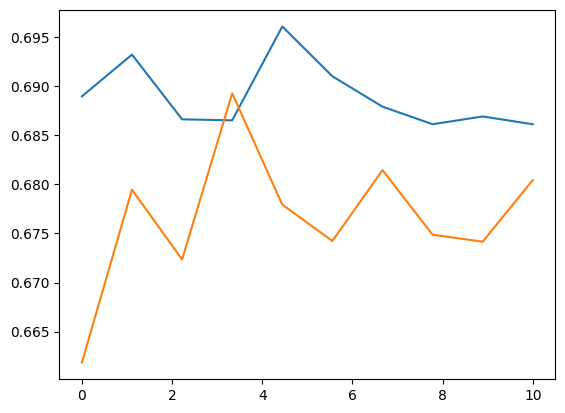

In [ ]:
# plot train and valid loss
x = np.linspace(0, len(train_loss), len(train_loss))
plt.plot(x, train_loss)
x1 = np.linspace(0, len(valid_loss), len(valid_loss))
plt.plot(x1, valid_loss)

In [ ]:
test_net(my_vgg, test_loader)

Accuracy: 0.5833333333333334
